In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=3
CHANNELS=3
EPOCHS=10

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Piston_Dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

In [ ]:
class_names=dataset.class_names
class_names

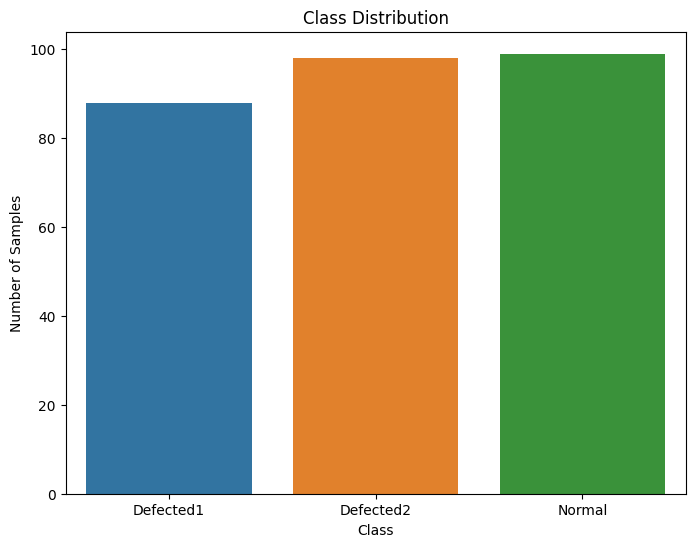

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Dataset directory
dataset_dir = "Piston_Dataset"

# List of classes
class_names = os.listdir(dataset_dir)

# Count the number of samples in each class
class_counts = [len(os.listdir(os.path.join(dataset_dir, cls))) for cls in class_names]

# Plot class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_names, y=class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.show()



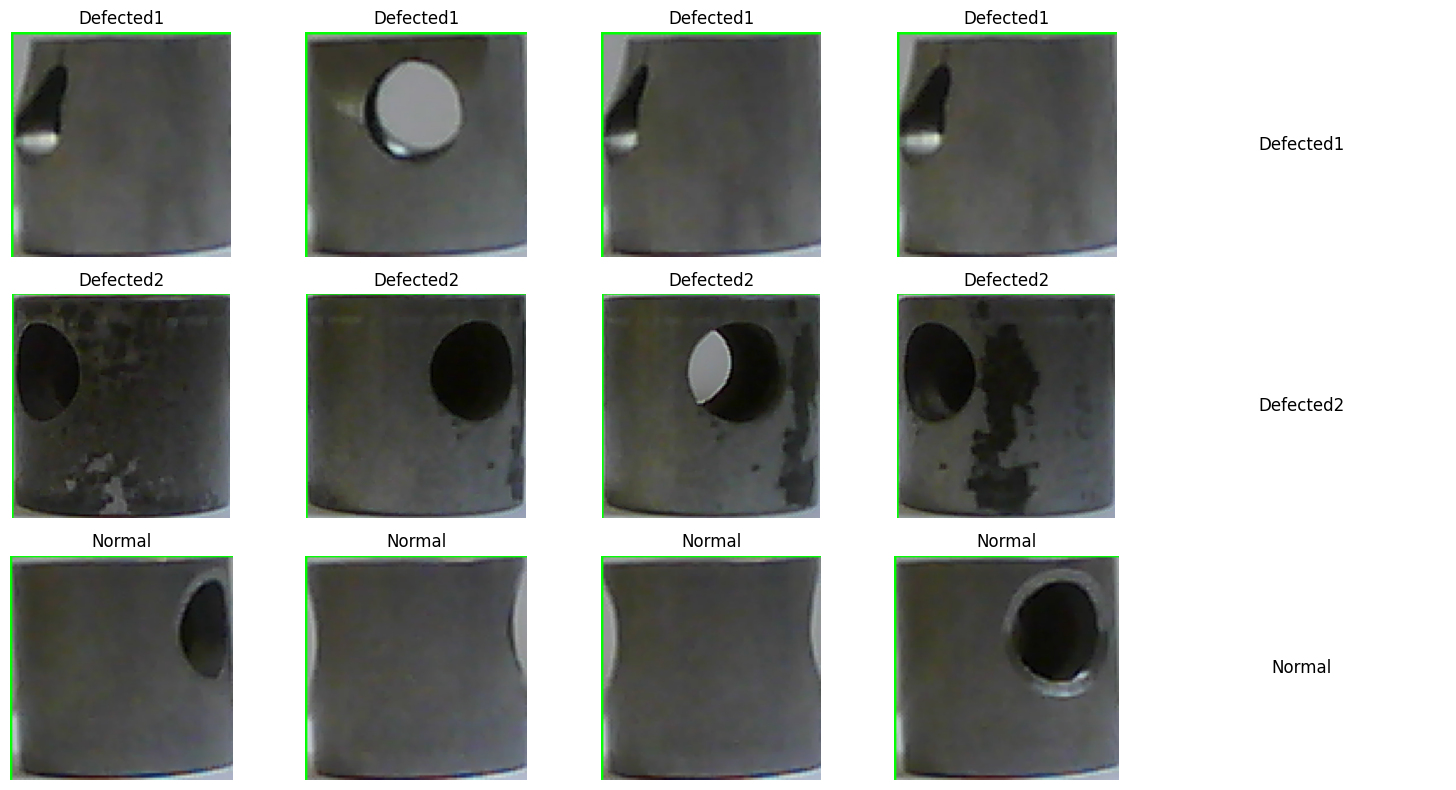

In [44]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.gridspec import GridSpec

# Dataset directory
dataset_dir = "Piston_Dataset/"

# List of classes
class_names = os.listdir(dataset_dir)

# Function to get random images from each class
def get_random_images(class_name, num_images=4):
    class_dir = os.path.join(dataset_dir, class_name)
    image_files = os.listdir(class_dir)
    random_images = random.sample(image_files, num_images)
    return [Image.open(os.path.join(class_dir, img)) for img in random_images]

# Number of images per class to display
num_images_per_class = 4

# Create a grid layout for the images
grid_rows = len(class_names)
grid_cols = num_images_per_class + 1  # Additional column for class name
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(grid_rows, grid_cols, figure=fig)

# Visualize random images from each class in a single frame
for i, cls in enumerate(class_names):
    random_images = get_random_images(cls, num_images=num_images_per_class)
    for j, image in enumerate(random_images):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(image)
        ax.set_title(cls)
        ax.axis("off")
    
    # Add an empty subplot for the class name
    ax_class_name = fig.add_subplot(gs[i, num_images_per_class])
    ax_class_name.text(0.5, 0.5, cls, ha='center', va='center', fontsize=12)
    ax_class_name.axis("off")

# Adjust spacing and layout
plt.tight_layout()
plt.show()


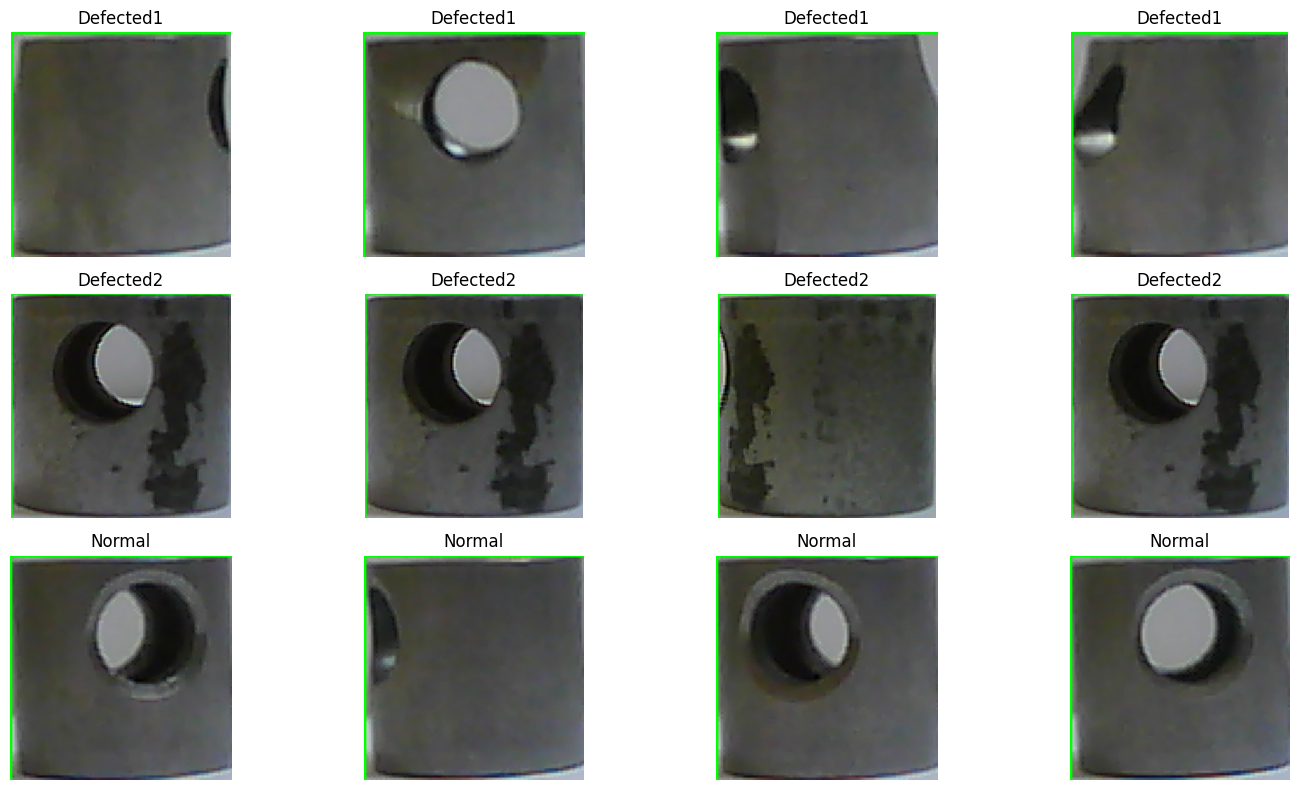

In [41]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Dataset directory
dataset_dir = "Piston_Dataset"

# List of classes
class_names = os.listdir(dataset_dir)

# Function to get random images from each class
def get_random_images(class_name, num_images=4):
    class_dir = os.path.join(dataset_dir, class_name)
    image_files = os.listdir(class_dir)
    random_images = random.sample(image_files, num_images)
    return [Image.open(os.path.join(class_dir, img)) for img in random_images]

# Visualize random images from each class in a single frame
num_images_per_class = 4
plt.figure(figsize=(15, 8))
for i, cls in enumerate(class_names):
    random_images = get_random_images(cls, num_images=num_images_per_class)
    for j, image in enumerate(random_images):
        plt.subplot(len(class_names), num_images_per_class, i * num_images_per_class + j + 1)
        plt.imshow(image)
        plt.title(cls)
        plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
len(dataset)

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

In [ ]:
len(val_ds)

In [ ]:
len(test_ds)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

In [46]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 1s 82ms/step - loss: 7.3358e-04 - accuracy: 1.0000


In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

10/10 [==============================] - 1s 60ms/step - loss: 7.3358e-04 - accuracy: 1.0000
Test Loss: 0.0007335801492445171, Test Accuracy: 1.0
1/1 [==============================] - 0s 87ms/step


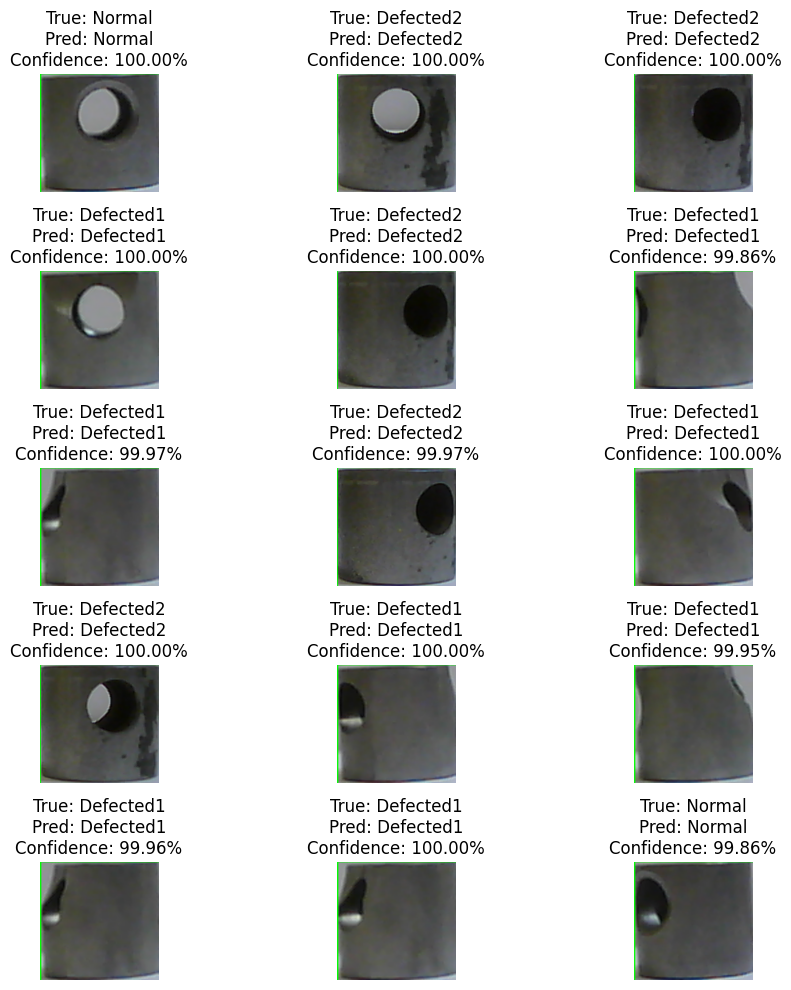

In [43]:
import numpy as np
import matplotlib.pyplot as plt
def visualize_predictions(model, test_ds, class_names, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(test_ds.take(num_samples)):
        predictions = model.predict(images)
        pred_labels = np.argmax(predictions, axis=-1)
        confidence_scores = np.max(predictions, axis=-1) * 100  # Convert to percentage

        for j in range(images.shape[0]):
            plt.subplot(num_samples, 5, i * 5 + j + 1)
            plt.imshow(images[j].numpy().astype("uint8"))
            plt.title(f"True: {class_names[labels[j]]}\nPred: {class_names[pred_labels[j]]}\nConfidence: {confidence_scores[j]:.2f}%")
            plt.axis("off")

    plt.tight_layout()
    plt.show()


# After model.evaluate() function
scores = model.evaluate(test_ds)
print(f"Test Loss: {scores[0]}, Test Accuracy: {scores[1]}")

# Visualize sample predictions
visualize_predictions(model, test_ds, class_names)



10/10 [==============================] - 1s 78ms/step - loss: 7.3358e-04 - accuracy: 1.0000
Test Loss: 0.0007335801492445171, Test Accuracy: 1.0
1/1 [==============================] - 0s 91ms/step


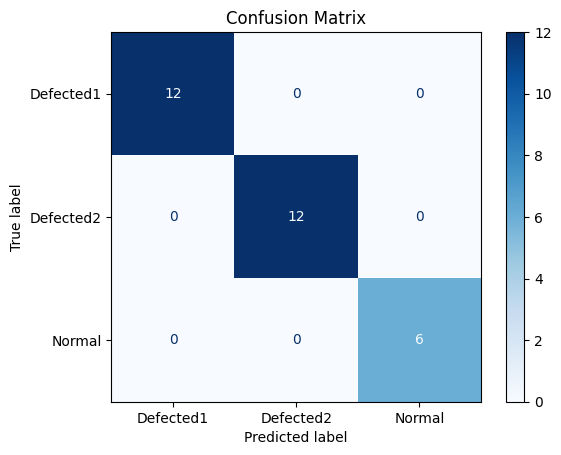

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_ds, class_names):
    true_labels = []
    predicted_labels = []
    for images, labels in test_ds:
        predictions = model.predict(images)
        pred_labels = np.argmax(predictions, axis=-1)
        true_labels.extend(labels)
        predicted_labels.extend(pred_labels)
    
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()
# After model.evaluate() function
scores = model.evaluate(test_ds)
print(f"Test Loss: {scores[0]}, Test Accuracy: {scores[1]}")
# Plot confusion matrix
plot_confusion_matrix(model, test_ds, class_names)

1/1 [==============================] - 0s 72ms/step


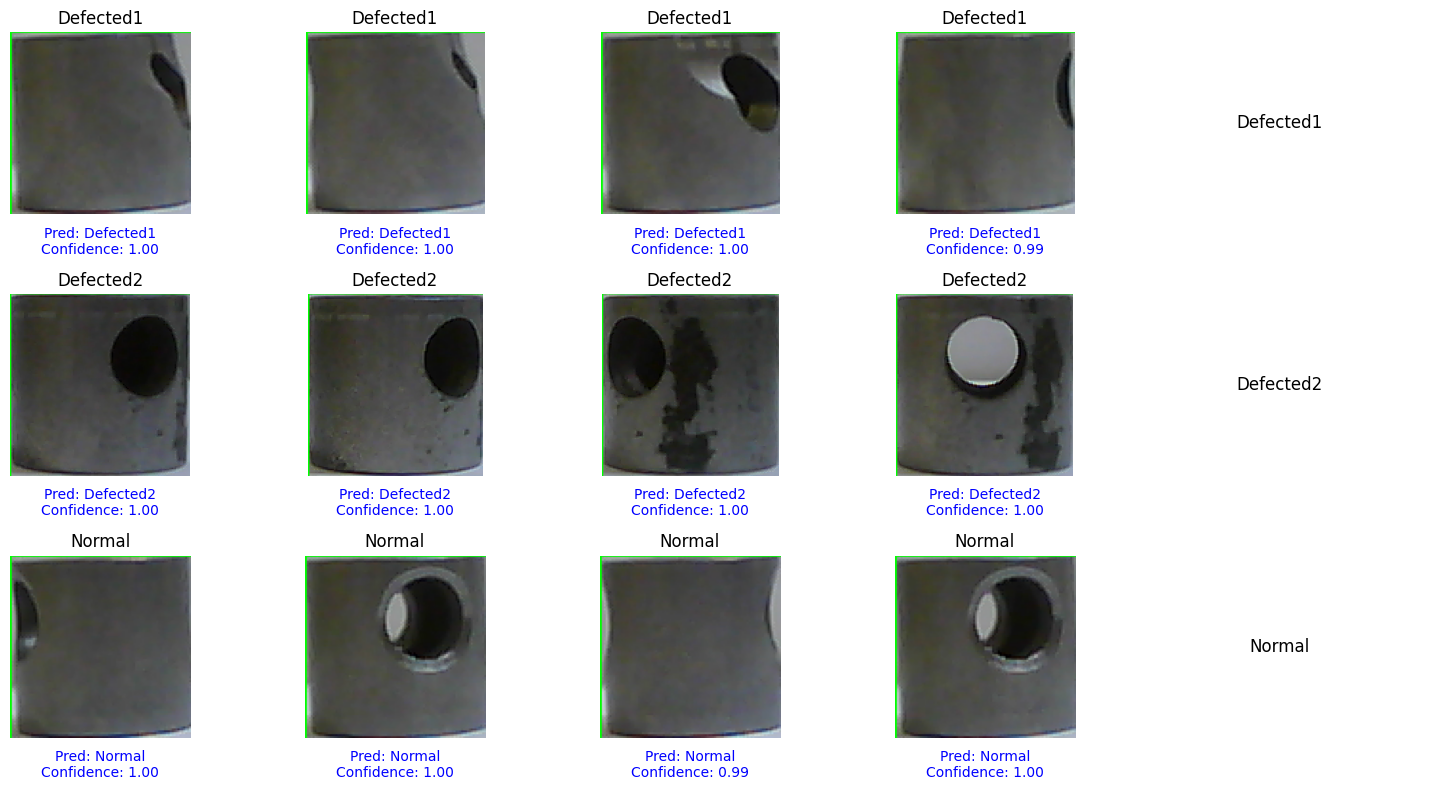

In [45]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Assuming you have already defined the model and class_names

# Function to get random images from each class
def get_random_images(class_name, num_images=4):
    class_dir = os.path.join(dataset_dir, class_name)
    image_files = os.listdir(class_dir)
    random_images = random.sample(image_files, num_images)
    return [Image.open(os.path.join(class_dir, img)) for img in random_images]

# Number of images per class to display
num_images_per_class = 4

# Create a grid layout for the images
grid_rows = len(class_names)
grid_cols = num_images_per_class + 1  # Additional column for class name and prediction
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(grid_rows, grid_cols, figure=fig)

# Visualize random images and their predictions from each class in a single frame
for i, cls in enumerate(class_names):
    random_images = get_random_images(cls, num_images=num_images_per_class)
    for j, image in enumerate(random_images):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(image)
        ax.set_title(cls)
        ax.axis("off")

        # Get the prediction for the current image
        image_array = np.array(image)
        image_array = np.expand_dims(image_array, axis=0)
        prediction = model.predict(image_array)
        pred_label = np.argmax(prediction[0])
        confidence_score = np.max(prediction[0])

        # Add the prediction below the image
        ax.text(0.5, -0.15, f"Pred: {class_names[pred_label]}\nConfidence: {confidence_score:.2f}",
                ha='center', va='center', transform=ax.transAxes, fontsize=10, color='blue')

    # Add an empty subplot for the class name
    ax_class_name = fig.add_subplot(gs[i, num_images_per_class])
    ax_class_name.text(0.5, 0.5, cls, ha='center', va='center', fontsize=12)
    ax_class_name.axis("off")

# Adjust spacing and layout
plt.tight_layout()
plt.show()


In [ ]:
model.save("MySavedModel")

In [ ]:
model_version=1
model.save(f"Saved_Model {model_version}")